### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupKFold
from scipy import stats
import os
import time
from tqdm import tqdm
import utils  # Do seu utils.py

### Audio Preprocessing

In [2]:
# --- Configuração ---
METADATA_DIR = '../fma_metadata'
AUDIO_DIR_GENRES = '../fma_datasets/fma_small_genres'
# Arquivos de cache para os espectrogramas
FEATURE_FILE_X = '../preprocessed_features/fma_small_spectrograms_X_3s_25overlap.npy'
FEATURE_FILE_y = '../preprocessed_features/fma_small_spectrograms_y_3s_25overlap.npy'
FEATURE_FILE_groups = '../preprocessed_features/fma_small_spectrograms_groups_3s_25overlap.npy'
N_CLASSES = 8 # 8 gêneros no fma_small

# --- Carregar Metadados (Igual ao v2) ---
tracks = utils.load(f'{METADATA_DIR}/tracks.csv')

small_mask = tracks[('set', 'subset')] == 'small'
y_all_labels_pd = tracks.loc[small_mask, ('track', 'genre_top')]
splits_pd = tracks.loc[small_mask, ('set', 'split')]

# --- Codificar os Gêneros (Labels) ---
label_encoder = LabelEncoder()
y_all_encoded_np = label_encoder.fit_transform(y_all_labels_pd).astype(np.int32)
class_names = label_encoder.classes_

# --- Criar DataFrame de referência ---
track_metadata = pd.DataFrame({
    'genre_top': y_all_labels_pd,
    'genre_encoded': y_all_encoded_np,
    'split': splits_pd
}, index=y_all_labels_pd.index)

print(f"Metadados carregados para {track_metadata.shape[0]} faixas 'small'.")
print(f"Gêneros: {class_names}")

Metadados carregados para 8000 faixas 'small'.
Gêneros: ['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']


In [3]:
# Parâmetros de Janelamento e Espectrograma
WINDOW_SIZE_SEC = 3
OVERLAP_PERCENT = 0.25
SR = 22050
N_MELS = 128   # Altura da "imagem" do espectrograma
N_FFT = 2048
HOP_LENGTH = 512 # Resultará na "largura" da imagem

# CALCULA A LARGURA FIXA (shape[1])
# samples_per_window = 3 * 22050 = 66150
# width = ceil(66150 / 512) = 130
SPEC_WIDTH = int(np.ceil((WINDOW_SIZE_SEC * SR) / HOP_LENGTH))
SPEC_SHAPE = (N_MELS, SPEC_WIDTH) # (128, 130)

def gerar_melspectrogram_janelado(file_path, sr=SR, window_size_sec=WINDOW_SIZE_SEC, overlap_percent=OVERLAP_PERCENT, target_shape=SPEC_SHAPE, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """
    Extrai mel-espectrogramas de 3s com 25% de sobreposição.
    MODIFICADO para garantir shape fixo (padding/truncate).
    """
    all_window_specs = []
    
    try:
        y, sr_loaded = librosa.load(file_path, mono=True, sr=sr, res_type='kaiser_fast')
        
        samples_per_window = window_size_sec * sr
        hop_size = int(samples_per_window * (1.0 - overlap_percent))
        
        if len(y) < samples_per_window:
            #print(f"Aviso: Áudio {file_path} mais curto que {window_size_sec}s. Pulando.")
            return []

        # Cria as janelas (frames) com sobreposição (lógica do v2)
        y_frames = librosa.util.frame(y, frame_length=samples_per_window, hop_length=hop_size, axis=0)
        
        for y_window in y_frames:
            # Gera o Mel-Espectrograma para a janela
            S = librosa.feature.melspectrogram(y=y_window, sr=sr, n_mels=target_shape[0], n_fft=n_fft, hop_length=hop_length)
            # Converte para dB
            S_db = librosa.power_to_db(S, ref=np.max)
            
            # Garante que a "largura" do espectrograma seja consistente
            # Isso evita o erro de "pickle" do NumPy
            S_db = librosa.util.fix_length(S_db, size=target_shape[1], axis=1)
            
            all_window_specs.append(S_db.astype(np.float32)) # Salva como float32
            
    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return []
        
    return all_window_specs

In [4]:
# Para garantir que as variáveis existam fora do escopo do 'if'
X_np = None
y_encoded_np = None
groups_np = None

# Verifica se os arquivos de cache existem
if not (os.path.exists(FEATURE_FILE_X) and 
        os.path.exists(FEATURE_FILE_y) and 
        os.path.exists(FEATURE_FILE_groups)):
    
    print(f"Arquivos de espectrograma não encontrados. Iniciando extração (2 passagens)...")
    
    # --- PASSAGEM 1: Contar o número total de janelas ---
    
    def get_window_count(file_path, sr=SR, window_size_sec=WINDOW_SIZE_SEC, overlap_percent=OVERLAP_PERCENT):
        # Esta função é mais leve, apenas carrega o áudio e conta os frames
        try:
            y, sr_loaded = librosa.load(file_path, mono=True, sr=sr, res_type='kaiser_fast')
            samples_per_window = window_size_sec * sr
            if len(y) < samples_per_window: return 0
            hop_size = int(samples_per_window * (1.0 - overlap_percent))
            y_frames = librosa.util.frame(y, frame_length=samples_per_window, hop_length=hop_size, axis=0)
            return y_frames.shape[0] # Retorna o número de janelas
        except Exception:
            return 0

    print("Passagem 1/2: Contando janelas...")
    total_janelas = 0
    all_track_ids_para_contagem = [] # Usado para saber quais faixas processar na Passagem 2
    
    for track_id, row in tqdm(track_metadata.iterrows(), total=track_metadata.shape[0]):
        genre_top = row['genre_top']
        file_path = f"{AUDIO_DIR_GENRES}/{genre_top}/{track_id:06d}.mp3"
        
        if not os.path.exists(file_path): continue
            
        n_janelas = get_window_count(file_path)
        if n_janelas > 0:
            total_janelas += n_janelas
            all_track_ids_para_contagem.append((track_id, row, n_janelas))

    print(f"\nContagem concluída. Total de janelas a serem extraídas: {total_janelas}")
    
    # --- PASSAGEM 2: Extrair e Salvar em Arrays (memmap) ---
    
    # Usa o SPEC_SHAPE definido na Célula 3 (ex: (128, 130))
    final_shape = (total_janelas, SPEC_SHAPE[0], SPEC_SHAPE[1])
    
    # Cria os arrays no disco (np.memmap para X)
    os.makedirs(os.path.dirname(FEATURE_FILE_X), exist_ok=True)
    
    # Criamos um nome temporário para o arquivo memmap
    MEMMAP_TEMP_FILE = FEATURE_FILE_X + '.temp'
    if os.path.exists(MEMMAP_TEMP_FILE):
        os.remove(MEMMAP_TEMP_FILE)
        
    X_np_memmap = np.memmap(MEMMAP_TEMP_FILE, dtype='float32', mode='w+', shape=final_shape)
    y_encoded_np_temp = np.zeros(total_janelas, dtype=np.int32)
    groups_np_temp = np.zeros(total_janelas, dtype=np.int32)

    print(f"Passagem 2/2: Extraindo espectrogramas para {MEMMAP_TEMP_FILE} (Shape: {final_shape})...")
    
    idx_escrita_atual = 0
    
    for track_id, row, n_janelas in tqdm(all_track_ids_para_contagem):
        genre_top = row['genre_top']
        file_path = f"{AUDIO_DIR_GENRES}/{genre_top}/{track_id:06d}.mp3"
        
        window_specs = gerar_melspectrogram_janelado(file_path)
        
        for i, spec in enumerate(window_specs):
            if i >= n_janelas: break 
            
            X_np_memmap[idx_escrita_atual] = spec
            y_encoded_np_temp[idx_escrita_atual] = row['genre_encoded']
            groups_np_temp[idx_escrita_atual] = track_id
            idx_escrita_atual += 1

    # ***** A CORREÇÃO ESTÁ AQUI *****
    
    # 1. Salva o X (lendo do memmap e salvando como .npy)
    print(f"\nConvertendo {MEMMAP_TEMP_FILE} para {FEATURE_FILE_X}...")
    np.save(FEATURE_FILE_X, X_np_memmap)
    
    # 2. Fecha e deleta o arquivo memmap temporário
    del X_np_memmap
    os.remove(MEMMAP_TEMP_FILE)
    
    # 3. Salva os outros arrays
    np.save(FEATURE_FILE_y, y_encoded_np_temp)
    np.save(FEATURE_FILE_groups, groups_np_temp)
    print(f"Extração concluída. Arquivos salvos.")
    
    # 4. Agora, carregamos as variáveis (do .npy recém-criado)
    print(f"Carregando arquivos recém-criados do cache...")
    X_np = np.load(FEATURE_FILE_X, mmap_mode='r')
    y_encoded_np = np.load(FEATURE_FILE_y)
    groups_np = np.load(FEATURE_FILE_groups)

else:
    print(f"Carregando espectrogramas cacheados de {FEATURE_FILE_X}...")
    # Carrega do disco (usando mmap_mode='r')
    X_np = np.load(FEATURE_FILE_X, mmap_mode='r') # <-- Esta linha agora funcionará
    y_encoded_np = np.load(FEATURE_FILE_y)
    groups_np = np.load(FEATURE_FILE_groups)
    print("Arquivos carregados.")

# Estas linhas agora funcionarão
print(f"Shape de X (amostras, n_mels, frames): {X_np.shape}")
print(f"Shape de y (labels): {y_encoded_np.shape}")
print(f"Shape de groups (track_ids): {groups_np.shape}")

Carregando espectrogramas cacheados de ../preprocessed_features/fma_small_spectrograms_X_3s_25overlap.npy...
Arquivos carregados.
Shape de X (amostras, n_mels, frames): (99278, 128, 130)
Shape de y (labels): (99278,)
Shape de groups (track_ids): (99278,)


### Treino dos Modelos

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

# Adiciona a dimensão do "canal" (1, pois é escala de cinza/monocromático)
X_np_cnn = X_np[..., np.newaxis]

# Converte labels para one-hot encoding
y_one_hot = tf.keras.utils.to_categorical(y_encoded_np, num_classes=N_CLASSES)

print(f"Shape de X para CNN (amostras, altura, largura, canais): {X_np_cnn.shape}")
print(f"Shape de y (one-hot): {y_one_hot.shape}")

2025-11-16 14:27:48.396347: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-16 14:27:48.754052: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-16 14:27:50.353770: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Shape de X para CNN (amostras, altura, largura, canais): (99278, 128, 130, 1)
Shape de y (one-hot): (99278, 8)


In [6]:

def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))

    # Bloco 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Bloco 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Bloco 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    # Bloco 4 (Opcional, depende da VRAM)
    # model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Flatten())
    
    # Camada Densa
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Camada de Saída
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Pega o shape de uma amostra (altura, largura, canais)
input_shape = X_np_cnn.shape[1:] 
model_cnn = build_cnn_model(input_shape, N_CLASSES)
model_cnn.summary()

/home/zurua/miniconda3/envs/tcc_cnn/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1763317671.222743  150498 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 130, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 130, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 33, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 33, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 34816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,456,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,551,176 (17.36 MB)

 Trainable params: 4,550,728 (17.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
from sklearn.utils import shuffle

n_splits = 10
gkf = GroupKFold(n_splits=n_splits)

# Armazenar resultados
fold_scores_acc_window = []
fold_scores_acc_track = []

all_preds_track = []
all_true_track = []

BATCH_SIZE = 32 # (Definido aqui, 32 ou 64 deve caber na sua VRAM de 6GB)

# Loop de Validação Cruzada (GroupKFold)
for fold, (train_idx, test_idx) in enumerate(gkf.split(X_np_cnn, y_one_hot, groups=groups_np)):
    print(f"--- Iniciando Fold {fold+1}/{n_splits} ---")
    
    # --- 1. Normalização (StandardScaler) em Chunks (Evita OOM na RAM) ---
    print("Ajustando o Scaler (partial_fit)...")
    scaler = StandardScaler()
    
    # Embaralha os índices de treino para um partial_fit mais representativo
    train_idx_shuffled = shuffle(train_idx)
    
    # Ajusta o scaler em lotes de 5000 amostras
    chunk_size = 5000
    for i in tqdm(range(0, len(train_idx_shuffled), chunk_size)):
        idx_chunk = train_idx_shuffled[i:i+chunk_size]
        
        # Carrega APENAS o chunk na RAM (do memmap)
        X_chunk = X_np_cnn[idx_chunk] 
        
        # Reshape para 2D (para o scaler)
        X_chunk_2d = X_chunk.reshape(X_chunk.shape[0], -1)
        scaler.partial_fit(X_chunk_2d)
        # Deleta o chunk da RAM
        del X_chunk, X_chunk_2d 

    print("Scaler ajustado.")

    # --- 2. Gerador de Dados (DataGenerator) para Treinamento ---
    # (Lê do memmap, aplica o scaler, e envia para a GPU em lotes)
    
    def data_generator(indices, batch_size):
        num_samples = len(indices)
        while True:
            # Embaralha os índices a cada época
            indices_shuffled = shuffle(indices)
            
            for offset in range(0, num_samples, batch_size):
                batch_indices = indices_shuffled[offset:offset + batch_size]
                
                # Carrega o lote do memmap para a RAM
                X_batch_ram = X_np_cnn[batch_indices]
                y_batch_ram = y_one_hot[batch_indices]
                
                # Normaliza o lote (agora é rápido)
                X_batch_scaled_2d = scaler.transform(X_batch_ram.reshape(X_batch_ram.shape[0], -1))
                
                # Retorna ao shape da CNN
                X_batch_scaled = X_batch_scaled_2d.reshape(X_batch_ram.shape)
                
                yield X_batch_scaled, y_batch_ram

    train_gen = data_generator(train_idx, BATCH_SIZE)
    
    # --- 3. Preparar Dados de Teste (Validação) ---
    # O conjunto de teste (10% = ~10k amostras = ~0.7GB) DEVE caber na RAM
    print("Preparando dados de validação...")
    X_test = X_np_cnn[test_idx]
    y_test = y_one_hot[test_idx]
    
    # Normaliza o X_test (carregando-o de uma vez)
    X_test_scaled_2d = scaler.transform(X_test.reshape(X_test.shape[0], -1))
    X_test_scaled = X_test_scaled_2d.reshape(X_test.shape)
    print("Dados de validação prontos.")

    # IDs de grupo para o conjunto de teste (para votação majoritária)
    groups_test_fold = groups_np[test_idx]
    y_true_labels_fold = y_encoded_np[test_idx] # Labels não-one-hot

    # --- 4. Treinamento ---
    model_cnn = build_cnn_model(input_shape, N_CLASSES) # Recria o modelo
    model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    steps_per_epoch = len(train_idx) // BATCH_SIZE
    
    history = model_cnn.fit(train_gen,
                            epochs=100,
                            steps_per_epoch=steps_per_epoch,
                            batch_size=BATCH_SIZE, # O Gerador controla o batch_size
                            validation_data=(X_test_scaled, y_test),
                            callbacks=[early_stopping],
                            verbose=1)
    
    # --- 5. Avaliação Nível Janela (Window) ---
    loss, acc = model_cnn.evaluate(X_test_scaled, y_test, verbose=0)
    fold_scores_acc_window.append(acc)
    print(f"Fold {fold+1} - Acurácia (Nível Janela): {acc:.4f}")

    # --- 6. Avaliação Nível Faixa (Track) por Votação Majoritária ---
    y_pred_window_probs = model_cnn.predict(X_test_scaled)
    y_pred_window_labels = np.argmax(y_pred_window_probs, axis=1) # Converte de one-hot
    
    df_fold = pd.DataFrame({
        'track_id': groups_test_fold,
        'y_true_window': y_true_labels_fold,
        'y_pred_window': y_pred_window_labels
    })

    grouped = df_fold.groupby('track_id')
    y_true_track = grouped['y_true_window'].first()
    y_pred_track = grouped['y_pred_window'].apply(lambda x: stats.mode(x, keepdims=True)[0][0])
    
    acc_fold_track = np.mean(y_true_track == y_pred_track)
    fold_scores_acc_track.append(acc_fold_track)
    print(f"Fold {fold+1} - Acurácia (Nível Faixa): {acc_fold_track:.4f}")
    
    all_preds_track.append(y_pred_track.values)
    all_true_track.append(y_true_track.values)

    # Limpar memória da GPU e RAM antes do próximo fold
    del X_test, y_test, X_test_scaled, model_cnn, train_gen
    tf.keras.backend.clear_session()

# --- Fim do Loop CV ---
print("\n--- Treinamento e Avaliação de CV Concluídos ---")

--- Iniciando Fold 1/10 ---
Ajustando o Scaler (partial_fit)...


100%|██████████| 18/18 [00:18<00:00,  1.01s/it]


Scaler ajustado.
Preparando dados de validação...
Dados de validação prontos.
Epoch 1/100


/home/zurua/miniconda3/envs/tcc_cnn/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-11-16 14:28:12.989563: I external/local_xla/xla/service/service.cc:163] XLA service 0x72c4900060f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-16 14:28:12.989606: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-11-16 14:28:13.040422: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-16 14:28:13.313687: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-16 14:28:13.440034: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none o

   5/2791 ━━━━━━━━━━━━━━━━━━━━ 1:33 33ms/step - accuracy: 0.1425 - loss: 3.9408

I0000 00:00:1763317699.069373  150971 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2791/2791 ━━━━━━━━━━━━━━━━━━━━ 71s 23ms/step - accuracy: 0.2707 - loss: 1.8804 - val_accuracy: 0.4360 - val_loss: 1.6845
Epoch 2/100


2025-11-16 14:29:13.940912: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1462', 8 bytes spill stores, 8 bytes spill loads



2791/2791 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - accuracy: 0.3425 - loss: 1.7149 - val_accuracy: 0.4759 - val_loss: 1.5722
Epoch 3/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.3685 - loss: 1.6205 - val_accuracy: 0.4951 - val_loss: 1.5202
Epoch 4/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.3965 - loss: 1.5401 - val_accuracy: 0.4939 - val_loss: 1.4727
Epoch 5/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.4306 - loss: 1.4582 - val_accuracy: 0.5135 - val_loss: 1.4262
Epoch 6/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 50s 18ms/step - accuracy: 0.4812 - loss: 1.3517 - val_accuracy: 0.5355 - val_loss: 1.3940
Epoch 7/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.5232 - loss: 1.2566 - val_accuracy: 0.5260 - val_loss: 1.4295
Epoch 8/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.5570 - loss: 1.1740 - val_accuracy: 0.5295 - val_loss: 1.4431
Epoch 9/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.5859 - los

100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


Scaler ajustado.
Preparando dados de validação...
Dados de validação prontos.
Epoch 1/100


/home/zurua/miniconda3/envs/tcc_cnn/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2791/2791 ━━━━━━━━━━━━━━━━━━━━ 57s 19ms/step - accuracy: 0.3162 - loss: 1.8228 - val_accuracy: 0.4736 - val_loss: 1.5616
Epoch 2/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 54s 15ms/step - accuracy: 0.4057 - loss: 1.6166 - val_accuracy: 0.5078 - val_loss: 1.4572
Epoch 3/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.4530 - loss: 1.4830 - val_accuracy: 0.5141 - val_loss: 1.4104
Epoch 4/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.4918 - loss: 1.3715 - val_accuracy: 0.5391 - val_loss: 1.3692
Epoch 5/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.5196 - loss: 1.2862 - val_accuracy: 0.5365 - val_loss: 1.4029
Epoch 6/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - accuracy: 0.5495 - loss: 1.1949 - val_accuracy: 0.5465 - val_loss: 1.4015
Epoch 7/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.5779 - loss: 1.1156 - val_accuracy: 0.5470 - val_loss: 1.4152
Epoch 8/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.6023 - los

100%|██████████| 18/18 [00:08<00:00,  2.03it/s]


Scaler ajustado.
Preparando dados de validação...
Dados de validação prontos.
Epoch 1/100


/home/zurua/miniconda3/envs/tcc_cnn/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2791/2791 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - accuracy: 0.2548 - loss: 1.9114 - val_accuracy: 0.3957 - val_loss: 1.7118
Epoch 2/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - accuracy: 0.3167 - loss: 1.7848 - val_accuracy: 0.4404 - val_loss: 1.5940
Epoch 3/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.3642 - loss: 1.6838 - val_accuracy: 0.5149 - val_loss: 1.5110
Epoch 4/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 48s 14ms/step - accuracy: 0.4066 - loss: 1.5853 - val_accuracy: 0.5121 - val_loss: 1.5038
Epoch 5/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.4379 - loss: 1.5027 - val_accuracy: 0.5197 - val_loss: 1.4653
Epoch 6/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.4739 - loss: 1.4052 - val_accuracy: 0.5445 - val_loss: 1.3974
Epoch 7/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.5156 - loss: 1.2991 - val_accuracy: 0.5257 - val_loss: 1.3965
Epoch 8/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.5495 - los

100%|██████████| 18/18 [00:00<00:00, 262.71it/s]


Scaler ajustado.
Preparando dados de validação...
Dados de validação prontos.
Epoch 1/100


/home/zurua/miniconda3/envs/tcc_cnn/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2791/2791 ━━━━━━━━━━━━━━━━━━━━ 57s 19ms/step - accuracy: 0.2678 - loss: 1.8918 - val_accuracy: 0.4020 - val_loss: 1.6727
Epoch 2/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 55s 19ms/step - accuracy: 0.3432 - loss: 1.7191 - val_accuracy: 0.4678 - val_loss: 1.5385
Epoch 3/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.3952 - loss: 1.5890 - val_accuracy: 0.4965 - val_loss: 1.4362
Epoch 4/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.4408 - loss: 1.4891 - val_accuracy: 0.5272 - val_loss: 1.4109
Epoch 5/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.4787 - loss: 1.3942 - val_accuracy: 0.5248 - val_loss: 1.3919
Epoch 6/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - accuracy: 0.5117 - loss: 1.3045 - val_accuracy: 0.5348 - val_loss: 1.3789
Epoch 7/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.5401 - loss: 1.2264 - val_accuracy: 0.5293 - val_loss: 1.4005
Epoch 8/100
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.5681 - los

100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


Scaler ajustado.
Preparando dados de validação...
Dados de validação prontos.
Epoch 1/100


/home/zurua/miniconda3/envs/tcc_cnn/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2792/2792 ━━━━━━━━━━━━━━━━━━━━ 68s 23ms/step - accuracy: 0.2981 - loss: 1.8250 - val_accuracy: 0.4823 - val_loss: 1.5297
Epoch 2/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - accuracy: 0.3667 - loss: 1.6564 - val_accuracy: 0.5237 - val_loss: 1.4191
Epoch 3/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.4217 - loss: 1.5294 - val_accuracy: 0.5370 - val_loss: 1.3949
Epoch 4/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.4745 - loss: 1.4125 - val_accuracy: 0.5414 - val_loss: 1.3876
Epoch 5/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.5094 - loss: 1.3179 - val_accuracy: 0.5491 - val_loss: 1.3613
Epoch 6/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.5373 - loss: 1.2352 - val_accuracy: 0.5472 - val_loss: 1.4209
Epoch 7/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.5699 - loss: 1.1457 - val_accuracy: 0.5454 - val_loss: 1.3981
Epoch 8/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - accuracy: 0.5935 - los

100%|██████████| 18/18 [00:09<00:00,  1.96it/s]


Scaler ajustado.
Preparando dados de validação...
Dados de validação prontos.
Epoch 1/100


/home/zurua/miniconda3/envs/tcc_cnn/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2792/2792 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.3083 - loss: 1.8190 - val_accuracy: 0.4795 - val_loss: 1.5367
Epoch 2/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 54s 19ms/step - accuracy: 0.3729 - loss: 1.6473 - val_accuracy: 0.5040 - val_loss: 1.4707
Epoch 3/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 61s 22ms/step - accuracy: 0.4139 - loss: 1.5354 - val_accuracy: 0.5182 - val_loss: 1.3880
Epoch 4/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.4593 - loss: 1.4299 - val_accuracy: 0.5223 - val_loss: 1.3912
Epoch 5/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.4941 - loss: 1.3448 - val_accuracy: 0.5418 - val_loss: 1.3519
Epoch 6/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.5293 - loss: 1.2548 - val_accuracy: 0.5544 - val_loss: 1.3490
Epoch 7/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.5563 - loss: 1.1764 - val_accuracy: 0.5478 - val_loss: 1.3664
Epoch 8/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.5820 - los

100%|██████████| 18/18 [00:09<00:00,  1.92it/s]


Scaler ajustado.
Preparando dados de validação...
Dados de validação prontos.


/home/zurua/miniconda3/envs/tcc_cnn/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - accuracy: 0.3030 - loss: 1.8474 - val_accuracy: 0.4308 - val_loss: 1.6194
Epoch 2/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - accuracy: 0.3615 - loss: 1.6834 - val_accuracy: 0.4637 - val_loss: 1.5565
Epoch 3/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.3973 - loss: 1.5840 - val_accuracy: 0.4955 - val_loss: 1.4611
Epoch 4/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.4386 - loss: 1.4950 - val_accuracy: 0.5339 - val_loss: 1.4162
Epoch 5/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.4782 - loss: 1.4049 - val_accuracy: 0.5378 - val_loss: 1.4166
Epoch 6/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.5114 - loss: 1.3207 - val_accuracy: 0.5465 - val_loss: 1.3918
Epoch 7/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.5405 - loss: 1.2307 - val_accuracy: 0.5418 - val_loss: 1.4281
Epoch 8/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 

100%|██████████| 18/18 [00:08<00:00,  2.02it/s]


Scaler ajustado.
Preparando dados de validação...
Dados de validação prontos.
Epoch 1/100


/home/zurua/miniconda3/envs/tcc_cnn/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2792/2792 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - accuracy: 0.2971 - loss: 1.8424 - val_accuracy: 0.4201 - val_loss: 1.6469
Epoch 2/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.3768 - loss: 1.6540 - val_accuracy: 0.4852 - val_loss: 1.5029
Epoch 3/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.4279 - loss: 1.5291 - val_accuracy: 0.5147 - val_loss: 1.4170
Epoch 4/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.4712 - loss: 1.4257 - val_accuracy: 0.5180 - val_loss: 1.4092
Epoch 5/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.5133 - loss: 1.3135 - val_accuracy: 0.5375 - val_loss: 1.3511
Epoch 6/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.5489 - loss: 1.2184 - val_accuracy: 0.5392 - val_loss: 1.3904
Epoch 7/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.5807 - loss: 1.1284 - val_accuracy: 0.5490 - val_loss: 1.3955
Epoch 8/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.6067 - los

100%|██████████| 18/18 [00:08<00:00,  2.11it/s]


Scaler ajustado.
Preparando dados de validação...
Dados de validação prontos.
Epoch 1/100


/home/zurua/miniconda3/envs/tcc_cnn/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2792/2792 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - accuracy: 0.2839 - loss: 1.8811 - val_accuracy: 0.4203 - val_loss: 1.7043
Epoch 2/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.3446 - loss: 1.7262 - val_accuracy: 0.4738 - val_loss: 1.5488
Epoch 3/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.3924 - loss: 1.5983 - val_accuracy: 0.5055 - val_loss: 1.4640
Epoch 4/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.4259 - loss: 1.5177 - val_accuracy: 0.5190 - val_loss: 1.4426
Epoch 5/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.4592 - loss: 1.4408 - val_accuracy: 0.5348 - val_loss: 1.4224
Epoch 6/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 58s 21ms/step - accuracy: 0.4990 - loss: 1.3513 - val_accuracy: 0.5326 - val_loss: 1.4362
Epoch 7/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.5295 - loss: 1.2575 - val_accuracy: 0.5360 - val_loss: 1.4146
Epoch 8/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.5609 - los

100%|██████████| 18/18 [00:08<00:00,  2.19it/s]


Scaler ajustado.
Preparando dados de validação...
Dados de validação prontos.
Epoch 1/100


/home/zurua/miniconda3/envs/tcc_cnn/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2792/2792 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - accuracy: 0.2997 - loss: 1.8838 - val_accuracy: 0.4038 - val_loss: 1.6728
Epoch 2/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.3637 - loss: 1.7284 - val_accuracy: 0.4963 - val_loss: 1.5451
Epoch 3/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.4099 - loss: 1.6035 - val_accuracy: 0.5346 - val_loss: 1.3941
Epoch 4/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.4585 - loss: 1.4736 - val_accuracy: 0.5218 - val_loss: 1.3869
Epoch 5/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.4949 - loss: 1.3678 - val_accuracy: 0.5497 - val_loss: 1.3312
Epoch 6/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.5301 - loss: 1.2674 - val_accuracy: 0.5669 - val_loss: 1.2956
Epoch 7/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.5615 - loss: 1.1831 - val_accuracy: 0.5489 - val_loss: 1.3349
Epoch 8/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.5872 - los

### Resultados


========= Resultados Finais (Nível Faixa - Votação Majoritária) ==========
Acurácia Média (10-Fold CV): 0.5998 +/- 0.0122

--- Relatório de Classificação (Nível Faixa) ---
               precision    recall  f1-score   support

   Electronic       0.59      0.69      0.63       999
 Experimental       0.62      0.41      0.49       999
         Folk       0.58      0.71      0.64      1000
      Hip-Hop       0.71      0.78      0.75       997
 Instrumental       0.52      0.62      0.57      1000
International       0.67      0.65      0.66      1000
          Pop       0.40      0.25      0.30      1000
         Rock       0.66      0.69      0.67       999

     accuracy                           0.60      7994
    macro avg       0.59      0.60      0.59      7994
 weighted avg       0.59      0.60      0.59      7994


--- Matriz de Confusão (Nível Faixa) ---


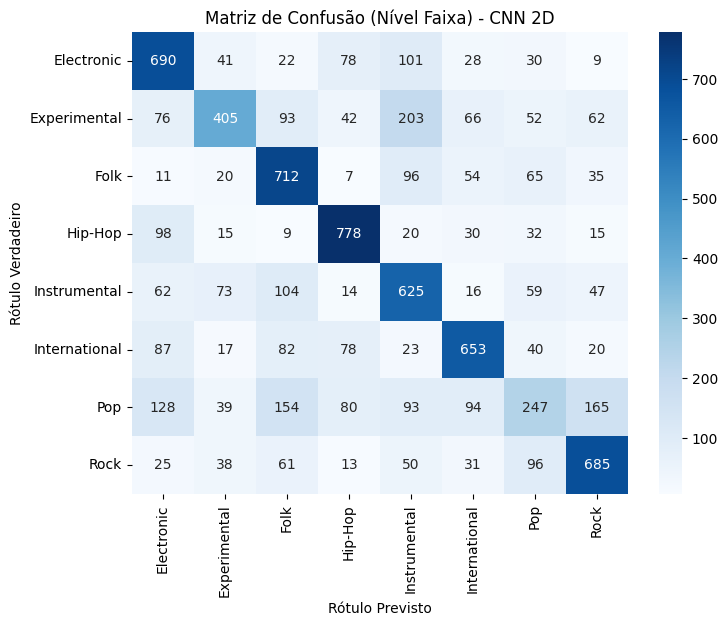

In [9]:
# Resultados da Acurácia por Faixa
mean_acc_track = np.mean(fold_scores_acc_track)
std_acc_track = np.std(fold_scores_acc_track)
print(f"\n========= Resultados Finais (Nível Faixa - Votação Majoritária) ==========")
print(f"Acurácia Média (10-Fold CV): {mean_acc_track:.4f} +/- {std_acc_track:.4f}")

# Matriz de Confusão e Relatório de Classificação Agregados (Nível Faixa)
y_true_agg = np.concatenate(all_true_track)
y_pred_agg = np.concatenate(all_preds_track)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n--- Relatório de Classificação (Nível Faixa) ---")
print(classification_report(y_true_agg, y_pred_agg, target_names=class_names))

print("\n--- Matriz de Confusão (Nível Faixa) ---")
cm = confusion_matrix(y_true_agg, y_pred_agg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão (Nível Faixa) - CNN 2D')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()